In [73]:
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import torch
from torch.optim import Adam, lr_scheduler
import torch.nn as nn
import albumentations as A
import cv2

import matplotlib
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageFont, ImageDraw, ImageEnhance


We start by loading our image. We will be working on a sample with LMLO view which contains a lesion at its center part. Bounding box information regarding the region of interests are stored in a JSON file which employs the **top-left coordinates** (`x` and `y`), **width** (`w`) and **height** (`h`) of the lesion.

In [84]:
PATH_TO_IMAGE = "data/sample1/original.jpeg"
PATH_TO_BBOX = "data/sample1/bbox.json"

We will then initialize our model and load the parameters. Our model is based on ResNet framework.

In [85]:
model = models.resnet50(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = model.to(device)

model.load_state_dict(torch.load("models/birads_padded.pt"))

<All keys matched successfully>

Our image loader function. `img_path` is the path to the image file whereas an optional `bbox_path` keyword argument can be provided to return the bounding box coordinates for visualization purposes.

In [86]:
def handle_json_bbox(input: str):
    # Replacing the '"' lateral with an empty string and then replacing "'" lateral with '"'  
    input = json.loads(input.replace("\"","").replace("'", "\""))
    bbs = []
    # Converting to the (x1, y1, x2, y2) format
    for bb in input:
        bbs.append([bb['x'], bb['y'], bb['x']+bb['width'], bb['y']+bb['height']])
    return bbs

def load_img(img_path, bbox_path=None):
    images = []
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(img, axis=0)  
    img = img.astype('float32') / 255.

    images = np.array(img[None])

    if bbox_path:
        with open(bbox_path) as f:
            bboxes = handle_json_bbox(f.read())
        return images, bboxes
    
    return images

def apply_bboxes(visualization, bbox):
    visualization_pil = Image.fromarray(visualization).convert('RGBA')
    draw = ImageDraw.Draw(visualization_pil)

    print(bbox)
    for i in range(len(bbox)):
        print(bbox[i])
        x1, y1, x2, y2 = list(map(int, bbox[i]))
        corners = [(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1,y1)]
        draw.line(corners, fill='red', width=3)

    visualization = np.array(visualization_pil)
    return visualization


In [87]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.layer4[-1]]
eigencam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
gradcam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
gradcampp = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

[[143.84022039323705, 273.5802118196663, 187.29545924439373, 307.0962583405003]]
[143.84022039323705, 273.5802118196663, 187.29545924439373, 307.0962583405003]
[[143.84022039323705, 273.5802118196663, 187.29545924439373, 307.0962583405003]]
[143.84022039323705, 273.5802118196663, 187.29545924439373, 307.0962583405003]
[[143.84022039323705, 273.5802118196663, 187.29545924439373, 307.0962583405003]]
[143.84022039323705, 273.5802118196663, 187.29545924439373, 307.0962583405003]


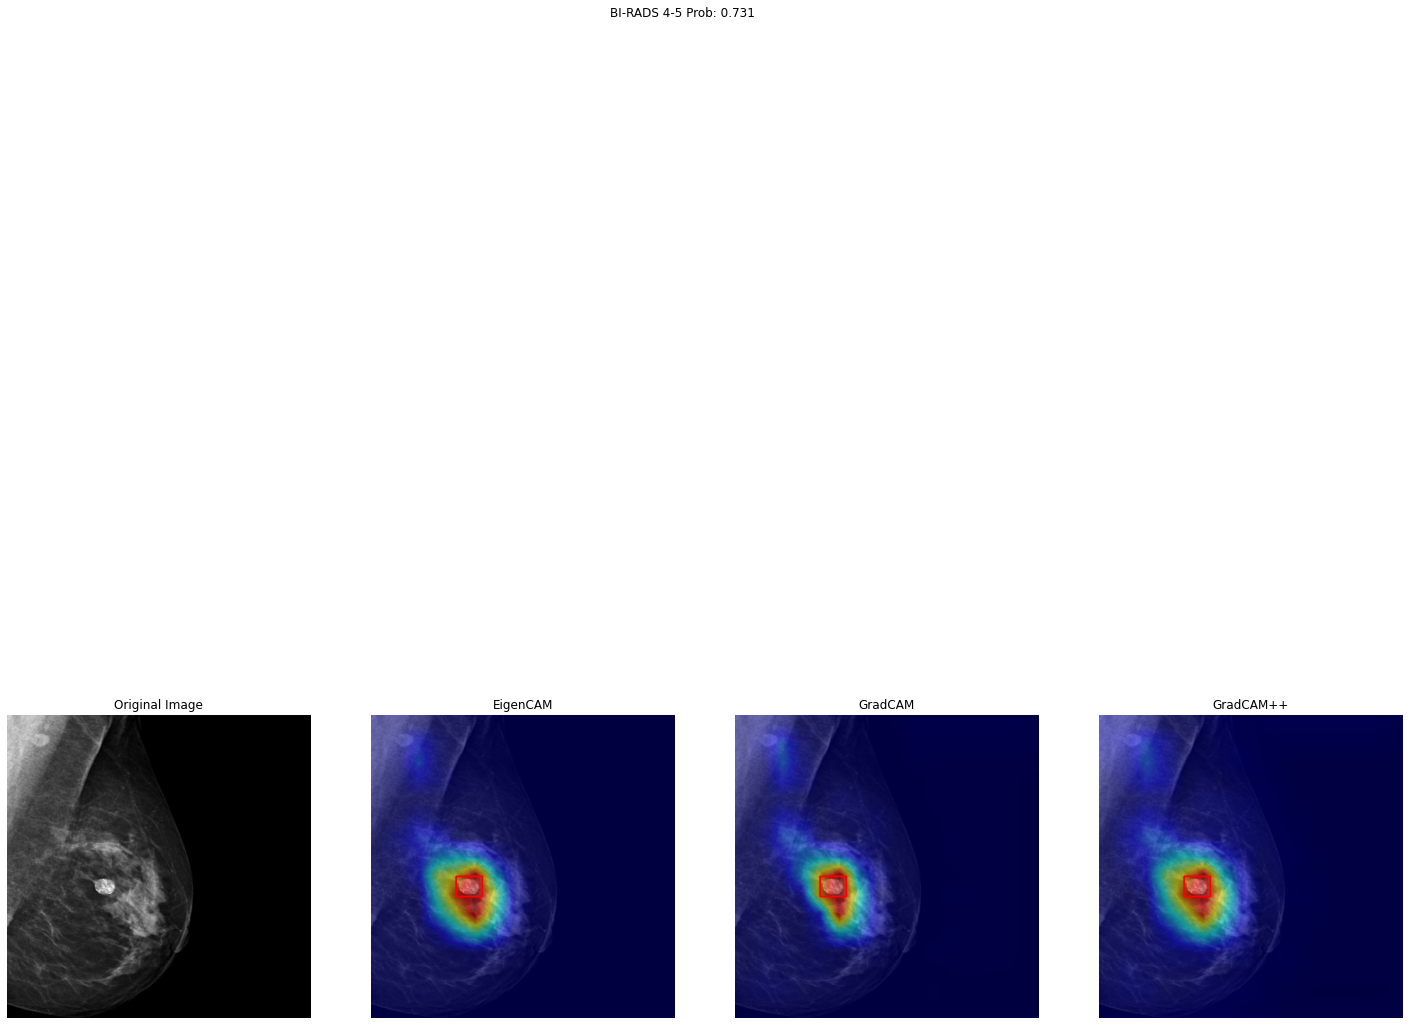

In [88]:
imgs, bboxes = load_img(PATH_TO_IMAGE, bbox_path=PATH_TO_BBOX)
for i in range(imgs.shape[0]):
    img = torch.tensor(imgs[i]).to(device)[None]
    img.requires_grad = True
    
    output = model(img)
    prob = nn.functional.softmax(output, dim=1).cpu().detach().numpy()
    
    bw_eigencam = eigencam(input_tensor=img)
    bw_gradcam = gradcam(input_tensor=img)
    bw_gradcampp = gradcampp(input_tensor=img)

    img_transposed = np.transpose(imgs[i], (1, 2, 0))
    bw_eigencam = np.transpose(bw_eigencam, (1, 2, 0))
    bw_gradcam = np.transpose(bw_gradcam, (1, 2, 0))
    bw_gradcampp = np.transpose(bw_gradcampp, (1, 2, 0))

    vis_eigencam = show_cam_on_image(img_transposed, bw_eigencam, use_rgb=True)
    vis_gradcam = show_cam_on_image(img_transposed, bw_gradcam, use_rgb=True)
    vis_gradcampp = show_cam_on_image(img_transposed, bw_gradcampp, use_rgb=True)

    if bboxes:
        vis_eigencam = apply_bboxes(vis_eigencam, bboxes)
        vis_gradcam = apply_bboxes(vis_gradcam, bboxes)
        vis_gradcampp = apply_bboxes(vis_gradcampp, bboxes)

    fig, ax = plt.subplots(1, 4, figsize=(25, 25))
    fig.suptitle(f"BI-RADS 4-5 Prob: {prob[:,1].item():.3}", verticalalignment='top')
    ax[0].imshow(img_transposed, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(vis_eigencam, cmap='gray')
    ax[1].set_title("EigenCAM")
    ax[1].axis('off')

    ax[2].imshow(vis_gradcam, cmap='gray')
    ax[2].set_title("GradCAM")
    ax[2].axis('off')

    ax[3].imshow(vis_gradcampp, cmap='gray')
    ax[3].set_title("GradCAM++")
    ax[3].axis('off')


